In [18]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('universal_tagset')
# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords

import pandas as pd
import scipy
from sklearn import *
import re

from SimpleCountVectorizer import *
from SimpleCountVectorizerAMC import *

from TFIDFVectorizer import *
from utils import *

from nltk.stem import WordNetLemmatizer, SnowballStemmer

import xgboost as xgb

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Count Vectorizer

In [19]:
train_df = pd.read_csv("./data/quora_train_data.csv")
test_df = pd.read_csv('./data/quora_test_data.csv')

In [20]:
train_df.shape, test_df.shape

((323432, 6), (80858, 6))

In [21]:
all_questions = cast_list_as_strings(list(train_df.loc[:, 'question1'])+list(train_df.loc[:, 'question2']))
print(set(type(x).__name__ for x in all_questions))

{'str'}


### Document cleaner

This function manages the cleaning of a document. After trying several things, we decided to simply filter by alphanumeric characters and replace the upper case with lower case.

In [22]:
def my_doc_cleaner(doc,
                  pat=r"[^a-zA-Z0-9]"):
    """
    Document cleaner. We allow alphanumeric characters.
    """
    
    # Allow alphanumeric characters
    doc_cleaner_pattern=pat
    clean_doc_pattern = re.compile(doc_cleaner_pattern)
    doc_clean = clean_doc_pattern.sub(" ", doc)
    return doc.lower()

### Tokenizer function

The tokenization function is the most important function of our CountVectorizer. It is in charge of deciding which tokens will represent a document (or phrase). As we can see, multiple functionalities have been added, which we will detail below:

* **Stopwords**: deactivated by default, it removes the most common English words. 
    This functionality made us reduce the evaluation metrics in that specific problem but it is a good functionality to take into account in future projects.


* **Numbers to words**: allows to solve problems like:
    * Q1: How much is 2+2?
    * Q2: What is the sum of two plus two?
    
    In this case the numbers are converted to their string representation thanks to a function implemented in the utils library.


* **Stemmer and Lemmatizer**: Two great allies of any text model, they serve to standardize the words by converting them to their root word, remove the 's' from the plurals...


* **N-grams**: To improve prediction and not use only tokens, we have introduced tuples of tokens. As in sklearn, we can specify the size of the N-grams with a function parameter.

* **N-tokens**: We added an extra field to indicate the number of tokens of that document. This feature helps to improve accuracy.

* **Duplicate question words**: In order to enhance the type of the question, we duplicate the keyword.

* **Duplicate verbs**: Verbs are extremely important in deciphering the underlying meaning of a sentence. Therefore, we attributed more importance to them via duplication. 

* **Duplicate nouns**: Nouns are extremely important in deciphering the underlying meaning of a sentence. Therefore, we attributed more importance to them via duplication.


In [23]:
# stpw = set(stopwords.words("english"))
stpw = []
question_words = ['who','what','when','where','why','how','which']
stemmer =  SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

In [24]:
def my_tokenizer_func(doc, 
                      ngrams=(1,3), 
                      numbers_to_words=True,
                      stop_words=stpw,
                      duplicate_question_words=question_words,
                      duplicate_verbs=False,
                      duplicate_nouns=True,
                      pat=r"(?u)\b\w\S*\w*\b",
                      lem=True,
                      stem=True,
                      add_num_tokens=True):
    
    # Split using a pattern
    # Notice that the pattern has been changed and now it accepts a wider
    # range of words. 
    
    # Example: V2.3.4 (A version of a program) will be transformed into 'v2.3.4'
    token_pattern = re.compile(pat)
    lst = token_pattern.findall(doc)
    
    # Transform numbers into words
    if numbers_to_words:
        lst = list(map(lambda x: num_conv(x), lst))
        
    # Drop stopwords 
    lst = list(filter(lambda x : x not in stop_words, lst))
    
    # Duplicate key_words
    if len(duplicate_question_words)>0:
        lst += [value for value in lst if value.lower() in duplicate_question_words]
    
     # Duplicate verbs
    if duplicate_verbs:
        lst += [x[0] for x in nltk.pos_tag(lst,tagset='universal') if x[1] == 'VERB' and len(x[0]) > 1]
        
    # Duplicate nouns
    if duplicate_nouns:
        lst += [x[0] for x in nltk.pos_tag(lst,tagset='universal') if x[1] == 'NOUN' and len(x[0]) > 1]
    
    #Stemmer
    if stem:
        lst = list(map(lambda x: stemmer.stem(x), lst))
    
    #Lemmatizer 
    if lem:
        lst = list(map(lambda x: lemmatizer.lemmatize(x), lst))
    
    # N-tokens
    ntoks = []
    if add_num_tokens:
        ntoks = [num_conv(str(len(lst))) + '_tokens']
    
    if ngrams==(1,1):
        return lst+ntoks
    
    # Generate ngrams
    lstRet = []
    for a in range(ngrams[0], ngrams[1]+1):
        if a!=1:
            lstRet+=list(zip(*[lst[i:] for i in range(a)]))
    return lstRet+ntoks if ngrams[0]!=1 else lst+lstRet+ntoks

### Fitting the improved SimpleCountVectorizer

In [25]:
count_vect = SimpleCountVectorizerAMC(
    doc_cleaner_func=my_doc_cleaner,
    tokenizer_func=my_tokenizer_func
)
count_vect.fit(all_questions)

SimpleCountVectorizerAMC(doc_cleaner_func=<function my_doc_cleaner at 0x7efdfd2b66a8>,
                         doc_cleaner_pattern='[^a-zA-Z]',
                         dtype=<class 'numpy.float32'>, min_word_counts=1,
                         token_pattern='(?u)\\b\\w\\w+\\b',
                         tokenizer_func=<function my_tokenizer_func at 0x7efdfd2b67b8>,
                         word_transformer_func=None)

### Transforming the datasets into sparse matrices

In [26]:
def get_features_from_df(df, vectorizer):
    """
    returns a sparse matrix containing the features build by the count vectorizer.
    Each row should contain features from question1 and question2.
    """
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))
    
    q1 = vectorizer.transform(q1_casted)
    q2 = vectorizer.transform(q2_casted)
    
    X_q1q2 = scipy.sparse.hstack((q1,q2))
        
    return X_q1q2

In [27]:
%time X_tr_q1q2 = get_features_from_df(train_df,count_vect)
%time X_te_q1q2  = get_features_from_df(test_df, count_vect)

X_tr_q1q2.shape, train_df.shape, test_df.shape, X_te_q1q2.shape

CPU times: user 10min 18s, sys: 4.81 s, total: 10min 23s
Wall time: 10min 17s
CPU times: user 2min 33s, sys: 924 ms, total: 2min 34s
Wall time: 2min 32s


((323432, 9425768), (323432, 6), (80858, 6), (80858, 9425768))

In [28]:
y_train = train_df["is_duplicate"].values
y_test = test_df['is_duplicate'].values

## Trying with a simple model (Linear Regression)

In [29]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", verbose=1, max_iter=1000)
logistic.fit(X_tr_q1q2, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [30]:
logistic.score(X_tr_q1q2, y_train), logistic.score(X_te_q1q2, y_test)

(0.9990075193549185, 0.8131662915234115)

### Save the model

In [31]:
import pickle 
pickle.dump(logistic, open('models/model_lr_count.pkl', 'wb'))

## Improving results (XGBoost)

In [32]:
import xgboost as xgb

N = 10000 # With early stopping
xgb_model = xgb.XGBClassifier(n_estimators=N)
xgb_model.fit(X_tr_q1q2, y_train, 
              verbose=10, 
              eval_set=[(X_tr_q1q2, y_train),(X_te_q1q2, y_test)], 
              early_stopping_rounds =10,
              eval_metric=['auc','logloss'],
              )

[0]	validation_0-auc:0.67782	validation_0-logloss:0.64980	validation_1-auc:0.67809	validation_1-logloss:0.65002
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[10]	validation_0-auc:0.75658	validation_0-logloss:0.56728	validation_1-auc:0.75471	validation_1-logloss:0.56883
[20]	validation_0-auc:0.78326	validation_0-logloss:0.54510	validation_1-auc:0.77918	validation_1-logloss:0.54829
[30]	validation_0-auc:0.79960	validation_0-logloss:0.52907	validation_1-auc:0.79427	validation_1-logloss:0.53340
[40]	validation_0-auc:0.80817	validation_0-logloss:0.51977	validation_1-auc:0.80184	validation_1-logloss:0.52499
[50]	validation_0-auc:0.81515	validation_0-logloss:0.51247	validation_1-auc:0.80794	validation_1-logloss:0.51846
[60]	validation_0-auc:0.82020	validation_0-logloss:0.50659	validation_1-auc:0.81192	validation_1-logloss:0.51351
[70]	validation_0-auc:0.82610	validation_0-lo

[710]	validation_0-auc:0.90493	validation_0-logloss:0.39721	validation_1-auc:0.86958	validation_1-logloss:0.43729
[720]	validation_0-auc:0.90546	validation_0-logloss:0.39645	validation_1-auc:0.86976	validation_1-logloss:0.43698
[730]	validation_0-auc:0.90591	validation_0-logloss:0.39583	validation_1-auc:0.86989	validation_1-logloss:0.43675
[740]	validation_0-auc:0.90633	validation_0-logloss:0.39524	validation_1-auc:0.87007	validation_1-logloss:0.43648
[750]	validation_0-auc:0.90677	validation_0-logloss:0.39452	validation_1-auc:0.87036	validation_1-logloss:0.43602
[760]	validation_0-auc:0.90715	validation_0-logloss:0.39391	validation_1-auc:0.87053	validation_1-logloss:0.43571
[770]	validation_0-auc:0.90761	validation_0-logloss:0.39323	validation_1-auc:0.87074	validation_1-logloss:0.43536
[780]	validation_0-auc:0.90799	validation_0-logloss:0.39270	validation_1-auc:0.87096	validation_1-logloss:0.43507
[790]	validation_0-auc:0.90847	validation_0-logloss:0.39200	validation_1-auc:0.87121	val

[1430]	validation_0-auc:0.92978	validation_0-logloss:0.35847	validation_1-auc:0.87997	validation_1-logloss:0.42008
[1440]	validation_0-auc:0.93000	validation_0-logloss:0.35810	validation_1-auc:0.88006	validation_1-logloss:0.41993
[1450]	validation_0-auc:0.93021	validation_0-logloss:0.35773	validation_1-auc:0.88013	validation_1-logloss:0.41982
[1460]	validation_0-auc:0.93041	validation_0-logloss:0.35744	validation_1-auc:0.88021	validation_1-logloss:0.41972
[1470]	validation_0-auc:0.93067	validation_0-logloss:0.35704	validation_1-auc:0.88030	validation_1-logloss:0.41957
[1480]	validation_0-auc:0.93084	validation_0-logloss:0.35673	validation_1-auc:0.88038	validation_1-logloss:0.41944
[1490]	validation_0-auc:0.93105	validation_0-logloss:0.35639	validation_1-auc:0.88045	validation_1-logloss:0.41934
[1500]	validation_0-auc:0.93132	validation_0-logloss:0.35591	validation_1-auc:0.88052	validation_1-logloss:0.41918
[1510]	validation_0-auc:0.93152	validation_0-logloss:0.35558	validation_1-auc:0.

[2150]	validation_0-auc:0.94379	validation_0-logloss:0.33280	validation_1-auc:0.88526	validation_1-logloss:0.41032
[2160]	validation_0-auc:0.94396	validation_0-logloss:0.33248	validation_1-auc:0.88533	validation_1-logloss:0.41019
[2170]	validation_0-auc:0.94413	validation_0-logloss:0.33216	validation_1-auc:0.88540	validation_1-logloss:0.41008
[2180]	validation_0-auc:0.94436	validation_0-logloss:0.33175	validation_1-auc:0.88553	validation_1-logloss:0.40989
[2190]	validation_0-auc:0.94451	validation_0-logloss:0.33145	validation_1-auc:0.88559	validation_1-logloss:0.40978
[2200]	validation_0-auc:0.94466	validation_0-logloss:0.33119	validation_1-auc:0.88566	validation_1-logloss:0.40967
[2210]	validation_0-auc:0.94486	validation_0-logloss:0.33085	validation_1-auc:0.88570	validation_1-logloss:0.40958
[2220]	validation_0-auc:0.94501	validation_0-logloss:0.33054	validation_1-auc:0.88575	validation_1-logloss:0.40949
[2230]	validation_0-auc:0.94513	validation_0-logloss:0.33030	validation_1-auc:0.

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

## Training curves

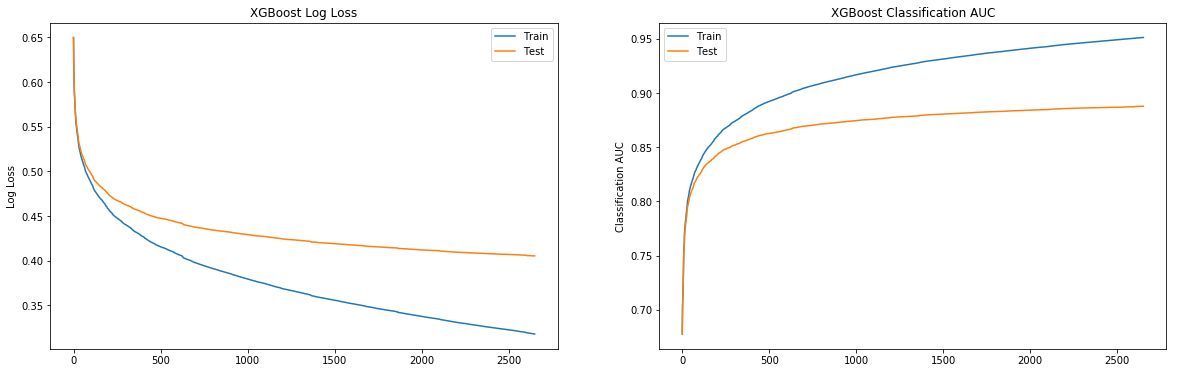

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig = plt.figure(figsize=(20,6))

# plot log loss
ax = fig.add_subplot(121)
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
ax.set_ylabel('Log Loss')
ax.set_title('XGBoost Log Loss')

# plot classification AUC
ax = fig.add_subplot(122)
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
ax.set_ylabel('Classification AUC')
ax.set_title('XGBoost Classification AUC')
plt.show()

### Save the model

In [34]:
pickle.dump(xgb_model, open('models/model_xgb_count.pkl', 'wb'))

# TFIDF

In our case, TFIDF has a lower performance than SimpleCountVectorizer (with the default parameters it already had it). We have managed to raise the score a little bit although we only use the CountVectorizer implemented at the beginning to predict.

In [ ]:
tfidf_vectorizer = TFIDFVectorizer(count_vect.vocabulary, count_vect.word_to_ind, count_vect.tokenize)
tfidf_vectorizer.fit(all_questions)

In [ ]:
X_tfidf_tr_q1q2 = get_features_from_df(train_df, tfidf_vectorizer)
X_tfidf_te_q1q2  = get_features_from_df(test_df, tfidf_vectorizer)

X_tfidf_tr_q1q2.shape, train_df.shape, test_df.shape, X_tfidf_te_q1q2.shape

In [ ]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", verbose=1, max_iter=1000)
logistic.fit(X_tfidf_tr_q1q2, y_train)

logistic.score(X_tfidf_tr_q1q2, y_train), logistic.score(X_tfidf_te_q1q2, y_test)

In [ ]:
N = 10000 # With early stopping
xgb_model = xgb.XGBClassifier(n_estimators=N)
xgb_model.fit(X_tfidf_tr_q1q2, y_train, 
              verbose=10, 
              eval_set=[(X_tfidf_tr_q1q2, y_train),(X_tfidf_te_q1q2, y_test)], 
              early_stopping_rounds =10,
              eval_metric=['auc','logloss'],
              )

In [ ]:
pickle.dump(xgb_model, open('models/model_xgb_tfidf.pkl', 'wb'))